## Exploring simulated data files from LDMX

In this notebook we will explore the data files (also called ntuples) that we will use in our project.
`coffea`, `awkward1` and `matplotlib` are requirements.

In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

Here, we import the getData function in data.py to open the files (in this case, you can download the first file from: https://www.dropbox.com/s/72hfd0zlm7nq5du/kaons_pn_example.root?dl=0 and place it in the ldmx-helpers/data/directory - and replace the path below with your path).

This function will get us the data in a nice object that contains a dictionary for every entry compressed in this generator format.

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/cmantill/LDMX/ldmx-helpers/data/kaons_pn_example.root")

You can explore the dictionary by for example printing the first chunck of this dictionary.
For example:

In [3]:
ic=0
for chunk_dict in ldmx_dict:
    if ic==0: print(chunk_dict)
    ic+=1

[{Proc_id: 7, Sim_Kaon_pdgID: [310], Sim_Kaon_trkID: [3, ... 591, 591, 591, 591]}]


One annoying thing is that once you have run the generator cell you need to restart the kernel if you want to re-generate it (Generators in python can't be rewound). So let's run the same line again.

In [4]:
ldmx_dict = getData(chunks=True, fnames="/Users/cmantill/LDMX/ldmx-helpers/data/kaons_pn_example.root")

Now let's define a couple of functions to add more variables to out dictionary

In [5]:
# this is a generic function to extend the aray
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

# here we are adding the angle (w. respect to the beamline)
def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

# this allows us to flatten our array
def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [6]:
# let's define a couple of histograms
# each .Bin defines a new axis of the histogram

hists = {}
hists["Target_kaon_kin"] = hist.Hist("Target SP Kaons", 
                                hist.Cat("particle", "Particle"), 
                                hist.Bin("e", r"Energy [MeV]", 40, 0, 4000),
                                hist.Bin("pz", r"$p_z$ [MeV]", 40, 0, 4000),
                                hist.Bin("theta", r"$\theta [^{\circ}]$", 40, 0, 90),
                            )

hists["Target_kaon_dau1"] = hist.Hist("Target SP Kaons", 
                                hist.Cat("parent", "Parent Particle"), 
                                hist.Bin("e", r"Energy [MeV]", 40, 0, 4000),
                                hist.Bin("pz", r"$p_z$ [MeV]", 40, 0, 4000),
                                hist.Bin("theta", r"$\theta [^{\circ}]$", 40, 0, 90),
                            )

In [7]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)

    target_kaon = ldmx_events['Target_Kaon']
    
    target_kaon = target_kaon
    target_kaon = add_angle(target_kaon)
    target_kaon_dau1 = ldmx_events['Target_Kaon_dau1']
    target_kaon_dau1 = add_angle(target_kaon_dau1)
    
    masks_id = {'Kshort': 310,
                'Klong': 130,
                'Kpm': 321,
               }
    masses = {'Kshort': 497.648,
              'Klong': 497.648,
              'Kpm': 493.677
             }
    
    for part,pmask in masks_id.items():
        # let's define a pdgID mask
        part_mask = (abs(target_kaon.pdgID)==pmask)
        
        print('e',target_kaon[part_mask].e)
        hists["Target_kaon_kin"].fill(particle=part,
                                 e=flat(target_kaon[part_mask].e),
                                 pz=flat(target_kaon[part_mask].pz),
                                 theta=flat(target_kaon[part_mask].theta*(180/math.pi)),
                                )
        
        part_mask = (abs(target_kaon_dau1.mompdgID)==pmask)
        hists["Target_kaon_dau1"].fill(parent=part,
                                       e=flat(target_kaon_dau1[part_mask].e),
                                       pz=flat(target_kaon_dau1[part_mask].pz),
                                       theta=flat(target_kaon_dau1[part_mask].theta*(180/math.pi)),
                            )

In [8]:
nchunk = 0
for chunk in ldmx_dict:
    # I usually test my code in one chunck only
    #if nchunk >= 1: break
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1
e [[910], [890, 507], [640], [], [], [1.93e+03, ... [], [], [1.64e+03], [], [], [], []]
e [[], [], [], [862], [2.21e+03], [1.07e+03], ... [], [916], [961], [880], [], []]
e [[], [], [], [], [], [], [], [1.57e+03], ... [682], [], [686], [], [567], [781, 822]]


<Hist (particle,e,pz,theta) instance at 0x7f92e1725be0>


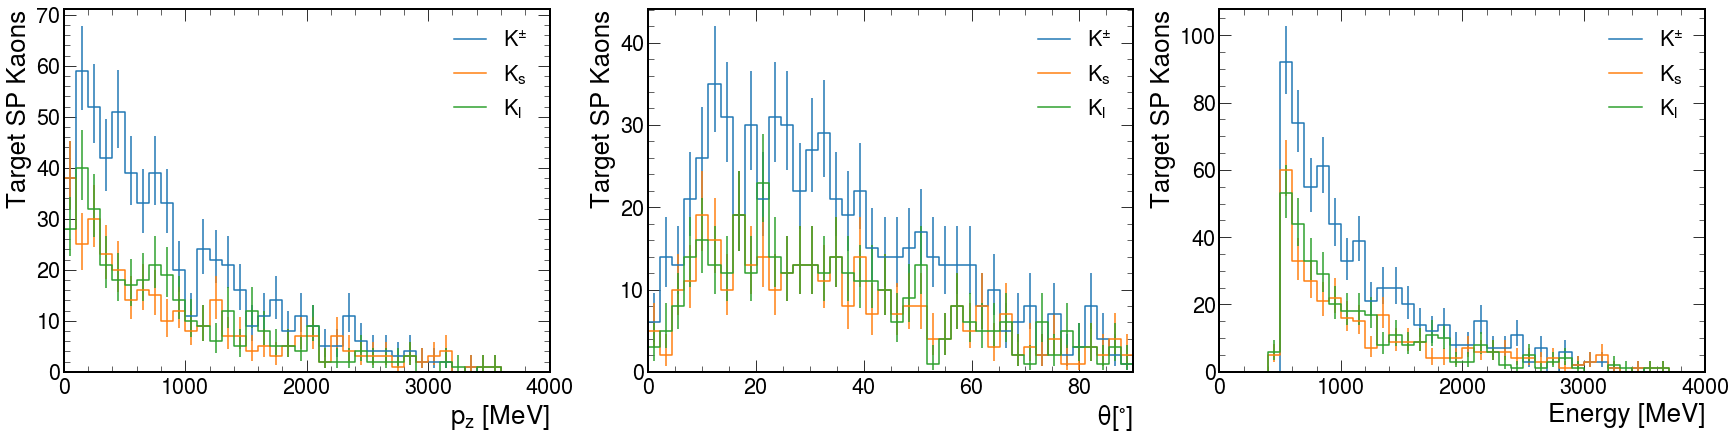

In [11]:
print(hists["Target_kaon_kin"])
fig, ax = plt.subplots(1,3,figsize=(24,6), constrained_layout=True)
hist.plot1d(hists["Target_kaon_kin"].sum('e','theta').integrate('particle','Kpm'),ax=ax[0]);
hist.plot1d(hists["Target_kaon_kin"].sum('e','theta').integrate('particle','Kshort'),ax=ax[0],clear=False);
hist.plot1d(hists["Target_kaon_kin"].sum('e','theta').integrate('particle','Klong'),ax=ax[0],clear=False);
leg = ax[0].legend([r'$K^{\pm}$',r'$K_s$',r'$K_l$'])

hist.plot1d(hists["Target_kaon_kin"].sum('pz','e').integrate('particle','Kpm'),ax=ax[1]);
hist.plot1d(hists["Target_kaon_kin"].sum('pz','e').integrate('particle','Kshort'),ax=ax[1],clear=False);
hist.plot1d(hists["Target_kaon_kin"].sum('pz','e').integrate('particle','Klong'),ax=ax[1],clear=False);
leg = ax[1].legend([r'$K^{\pm}$',r'$K_s$',r'$K_l$'])

hist.plot1d(hists["Target_kaon_kin"].sum('pz','theta').integrate('particle','Kpm'),ax=ax[2]);
hist.plot1d(hists["Target_kaon_kin"].sum('pz','theta').integrate('particle','Kshort'),ax=ax[2],clear=False);
hist.plot1d(hists["Target_kaon_kin"].sum('pz','theta').integrate('particle','Klong'),ax=ax[2],clear=False);
leg = ax[2].legend([r'$K^{\pm}$',r'$K_s$',r'$K_l$'])
